In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader
from utils import prep
from matplotlib import pyplot as plt
import numpy as np
import torch 
import json
import pandas as pd
from evaluation import evaluation
import copy

from itertools import product

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle


In [2]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 2, "Early NPDR": 1, "Late NPDR": 1}
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 3, "Early NPDR": 1, "Late NPDR": 2}
label_names = ["Healthy","DM", "Early NPDR","Late NPDR", "PDR"]
label_names = ["Healthy/DM", "Early NPDR","Late NPDR", "PDR"]

data_type = "DCP"

vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"





mode_train = "train"
train_pickle = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_{mode_train}_dataset.pkl"
train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_train,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = train_pickle
                                                        )

mode_test = "test"
test_pickle = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_{mode_test}_dataset.pkl"
test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_test,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = test_pickle
                                                        )

# make sure that if data is read from file the classes are still the correct
train_dataset.update_class(octa_dr_dict)
test_dataset.update_class(octa_dr_dict)

# number of classes are the unique labels the octa_dr_dict
num_classes = len(np.unique(list(octa_dr_dict.values())))

# imputation and normalization
prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)

prep.add_node_features(train_dataset, ["graph_1", "graph_2"])
prep.add_node_features(test_dataset, ["graph_1", "graph_2"])

#prep.add_global_node(train_dataset)
#prep.add_global_node(test_dataset)


node_mean_tensors, node_std_tensors = prep.hetero_graph_normalization_params(train_dataset)
#node_mean_tensors = torch.load(f"../{data_type}_node_mean_tensors_global_node_node_degs.pt")
#node_std_tensors = torch.load(f"../{data_type}_node_std_tensors_global_node_node_degs.pt")

#print(node_mean_tensors)
#print(node_std_tensors)

#node_mean_tensors = torch.load(f"checkpoints/{data_type}_node_mean_tensors_global_node_node_degs.pt")
#node_std_tensors = torch.load(f"checkpoints/{data_type}_node_std_tensors_global_node_node_degs.pt")

prep.hetero_graph_normalization(train_dataset, node_mean_tensors, node_std_tensors)
prep.hetero_graph_normalization(test_dataset, node_mean_tensors, node_std_tensors)


In [15]:

# do data imputation
#prep.hetero_graph_imputation(train_dataset)
#prep.hetero_graph_imputation(test_dataset)
#
#prep.add_node_features(train_dataset, ["graph_1", "graph_2"])
#prep.add_node_features(test_dataset, ["graph_1", "graph_2"])
#
## extract graph features
#train_g_extractor = graph_feature_extraction.GraphFeatureExtractor(train_dataset.hetero_graphs, mode=torch.mean)# 
#train_g_feature_dict = train_g_extractor.get_feature_dict()
#train_g_faz_feature_dict = train_g_extractor.get_faz_feature_dict()
#
#test_g_extractor = graph_feature_extraction.GraphFeatureExtractor(test_dataset.hetero_graphs, mode=torch.mean)# 
#test_g_feature_dict = test_g_extractor.get_feature_dict()
#test_g_faz_feature_dict = test_g_extractor.get_faz_feature_dict()
#
#prep.add_global_node(train_dataset)
#prep.add_global_node(test_dataset)

#train_dataset[0].x_dict["global"]

In [16]:
#octa_dr_dict_update = {"Healthy": 0, "DM": 0, "PDR": 2, "Early NPDR": 1, "Late NPDR": 1}
#train_dataset.update_class(octa_dr_dict_update)
#test_dataset.update_class(octa_dr_dict_update)
#
#num_classes = np.unique(list(octa_dr_dict_update.values())).shape[0]
#print(f"Number of classes: {num_classes}")

In [17]:
#extract segmentation features
#seg_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_seg"
#seg_extractor = seg_feature_extraction.SegFeatureExtractor(seg_path)
#seg_feature_dict = seg_extractor.get_feature_dict()


In [18]:
#train_comb_feature_dict = prep.create_combined_feature_dict(train_g_feature_dict,train_g_faz_feature_dict, seg_feature_dict, train_dataset)
#test_comb_feature_dict = prep.create_combined_feature_dict(test_g_feature_dict,test_g_faz_feature_dict, seg_feature_dict, test_dataset)

In [19]:

#x_train = np.array([val[0] for val in train_comb_feature_dict.values()])
#y_train = np.array([val[1] for val in train_comb_feature_dict.values()])
#
#x_test = np.array([val[0] for val in test_comb_feature_dict.values()])
#y_test = np.array([val[1] for val in test_comb_feature_dict.values()])

In [117]:
train_dataset.hetero_graph_list[0]

HeteroData(
  eye=False,
  y=[1],
  graph_id='0002_OS',
  graph_1={
    x=[6908, 19],
    pos=[6908, 2],
  },
  graph_2={
    x=[1861, 19],
    pos=[1861, 2],
  },
  (graph_1, to, graph_1)={ edge_index=[2, 27696] },
  (graph_2, to, graph_2)={ edge_index=[2, 7136] },
  (graph_1, to, graph_2)={ edge_index=[2, 8642] },
  (graph_2, rev_to, graph_1)={ edge_index=[2, 8642] }
)

In [3]:
# read the label_dict.json
with open("../label_dict.json", "r") as file:
    label_dict_full = json.load(file)
    #features_label_dict = json.load(file)
features_label_dict = copy.deepcopy(label_dict_full)


train_dataset_work = copy.deepcopy(train_dataset.hetero_graph_list)
test_dataset_work = copy.deepcopy(test_dataset.hetero_graph_list)

eliminate_features = {"graph_1":["num_voxels", "maxRadiusAvg", "hasNodeAtSampleBorder", "maxRadiusStd"], 
                      "graph_2":["centroid-0", "centroid-1", "orientation","solidity"]} # "feret_diameter_max", "equivalent_diameter",  #"centroid_weighted-0", "centroid_weighted-1", 

for key in eliminate_features.keys():
    for feat in eliminate_features[key]:
        idx = features_label_dict[key].index(feat)
        features_label_dict[key].remove(feat)
        for data in train_dataset_work:
            data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)
        for data in test_dataset_work:
            data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)



In [4]:
# load the feature label 
# just for the first graph

x_train = np.zeros((len(train_dataset_work), len(features_label_dict["graph_1"]) + len(features_label_dict["graph_2"])))
y_train = np.zeros((len(train_dataset_work),))
x_test = np.zeros((len(test_dataset_work), len(features_label_dict["graph_1"]) + len(features_label_dict["graph_2"])))
y_test = np.zeros((len(test_dataset_work),))




for i in range(len(train_dataset_work)):
    graph_1 = train_dataset_work[i]["graph_1"]
    graph_2 = train_dataset_work[i]["graph_2"]

    y_train[i] = train_dataset_work[i].y
    
    # average the features of all nodes in the graph 
    graph_1_avg = graph_1.x.numpy().mean(axis = 0)
    graph_2_avg = graph_2.x.numpy().mean(axis = 0)

    # add averages to the matrix
    x_train[i,:len(features_label_dict["graph_1"])] = graph_1_avg
    x_train[i,len(features_label_dict["graph_1"]):] = graph_2_avg

for i in range(len(test_dataset_work)):
    graph_1 = test_dataset_work[i]["graph_1"]
    graph_2 = test_dataset_work[i]["graph_2"]

    y_test[i] = test_dataset_work[i].y
    
    # average the features of all nodes in the graph 
    graph_1_avg = graph_1.x.numpy().mean(axis = 0)
    graph_2_avg = graph_2.x.numpy().mean(axis = 0)

    # add averages to the matrix
    x_test[i,:len(features_label_dict["graph_1"])] = graph_1_avg
    x_test[i,len(features_label_dict["graph_1"]):] = graph_2_avg


In [5]:
param_grid_rf = {'max_depth': [4, 5, 6, 8], 'max_features': ["sqrt", "log2"], 'class_weight': ['balanced','balanced_subsample', None], 'n_estimators': [100,  300]} 
#param_grid_rf = {'alpha': [0.001, 0.1, 100, 1000], 'class_weight': ['balanced', None], 'solver': ['auto', 'svd']}

clf = RandomForestClassifier
#clf = RidgeClassifier


best_params = None
best_metric = 0

# Hyperparameter search loop
for param_set in product(*param_grid_rf.values()):
    current_params = dict(zip(param_grid_rf.keys(), param_set))

    # Train the model on the training set
    current_model = clf(**current_params) 
    current_model.fit(x_train, y_train)

    # Evaluate on the validation set
    val_predictions = current_model.predict(x_test)
    #val_prob_pred = current_model.predict_proba(x_test)
    current_accuracy = accuracy_score(y_test, val_predictions)
    current_balanced_accuracy = balanced_accuracy_score(y_test, val_predictions)
    #if num_classes == 2:
    #    current_auc = roc_auc_score(
    #        y_true=y_test,
    #        y_score = val_prob_pred[:,1],
    #        multi_class="ovr",
    #        average="macro",
    #    )
    #else:
    #    current_auc = roc_auc_score(
    #        y_true=y_test,
    #        y_score = val_prob_pred,
    #        multi_class="ovr",
    #        average="macro",
    #    )
    kappa = cohen_kappa_score(y_test, val_predictions, weights="quadratic") # , weights="quadratic"
    metric =  kappa
    metric = current_balanced_accuracy
    # Update best parameters if current model is better
    if metric > best_metric:
        best_metric = metric
        best_params = current_params
        print(f"Balanced Accuracy: {current_balanced_accuracy}")
        print(f"Accuracy: {current_accuracy}")
        print(f"Kappa: {kappa}")


rf_best = clf(**best_params) # , class_weight='balanced'
_=rf_best.fit(x_train, y_train)

print("Best parameters:")
print(best_params)

Balanced Accuracy: 0.6080759330759331
Accuracy: 0.7668393782383419
Kappa: 0.7253532779561174
Balanced Accuracy: 0.619980694980695
Accuracy: 0.772020725388601
Kappa: 0.7286680670184085
Best parameters:
{'max_depth': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'n_estimators': 300}


In [82]:
## visualize a single tree
#estimator = rf_best.estimators_[5]
#
#from sklearn.tree import export_graphviz
## Export as dot file
#export_graphviz(estimator, out_file='tree.dot',
#                feature_names = features_label_dict["graph_1"] + features_label_dict["graph_2"],
#                class_names = label_names,
#                rounded = True, proportion = False,
#                precision = 2, filled = True)
#
## Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
#
## Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'tree.png')


{'max_depth': 4, 'max_features': 'sqrt', 'class_weight': 'balanced', 'n_estimators': 300}
0.7611111111111111
0.6757518406768914


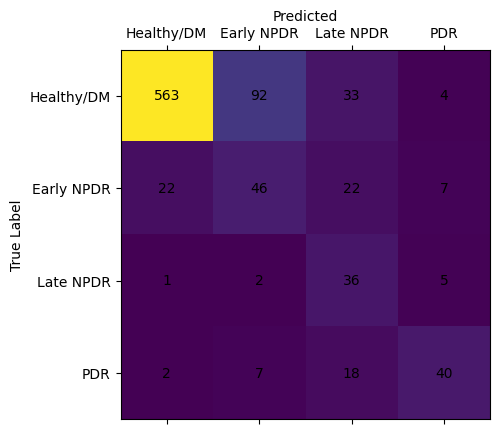

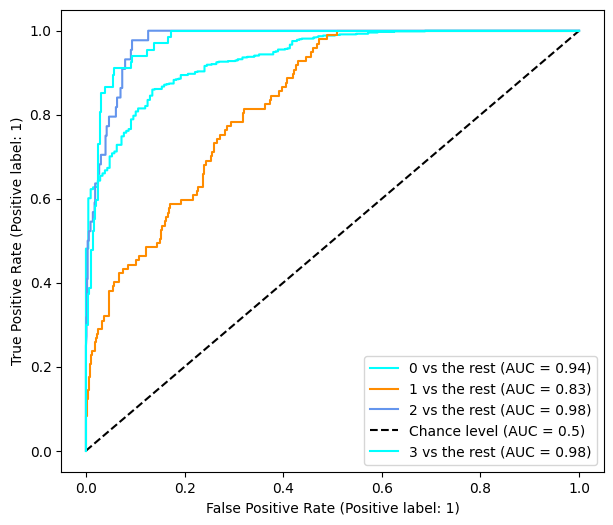

0.9295347409056475
0.729712578879949


In [6]:
print(best_params)

y_p = rf_best.predict(x_train)
print(accuracy_score(y_train, y_p))
print(balanced_accuracy_score(y_train, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_train, y_p, label_names, ax) #, ["Healthy/DM","PDR", "NPDR"]"Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()


y_prob = rf_best.predict_proba(x_train)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_train = label_binarizer.transform(y_train)


fig, ax = plt.subplots(figsize=(7, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

if num_classes == 2:
    RocCurveDisplay.from_predictions(
        y_train,
        y_prob[:, 1],
        name="ROC curve",
        ax=ax,
        color="red",
    )
else:
    for class_id, color in zip(range(num_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_train[:, class_id],
            y_prob[:, class_id],
            name=f"{class_id} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )


if num_classes == 2:
    mean_auc = roc_auc_score(
        y_true=y_train,
        y_score = y_prob[:,1],
        multi_class="ovr",
        average="macro",
    )
else:
    mean_auc = roc_auc_score(
        y_true=y_train,
        y_score = y_prob,
        multi_class="ovr",
        average="macro",
    )
plt.show()
print(mean_auc)
print(cohen_kappa_score(y_train, y_p, weights="quadratic"))

In [16]:
# get the samples where the gt is 3 and the prediction is 0 

pdr_true = np.where(y_train == 3)
healthy_pred = np.where(y_p == 0)

pdr_healthy = np.intersect1d(pdr_true, healthy_pred)
pdr_healthy

for sample in pdr_healthy:
    print(list(train_dataset.hetero_graphs.keys())[sample])
    

0121_OS
0341_OD


{'max_depth': 4, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample', 'n_estimators': 100}
0.7668393782383419
0.5847651222651222


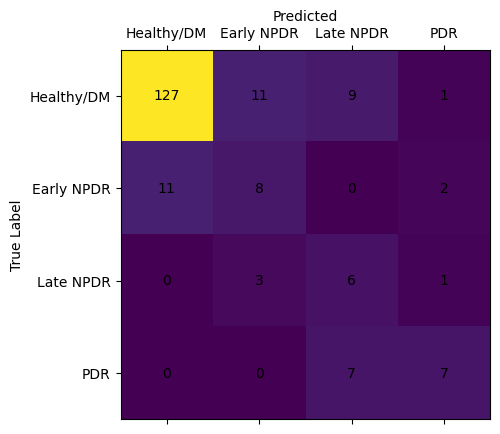

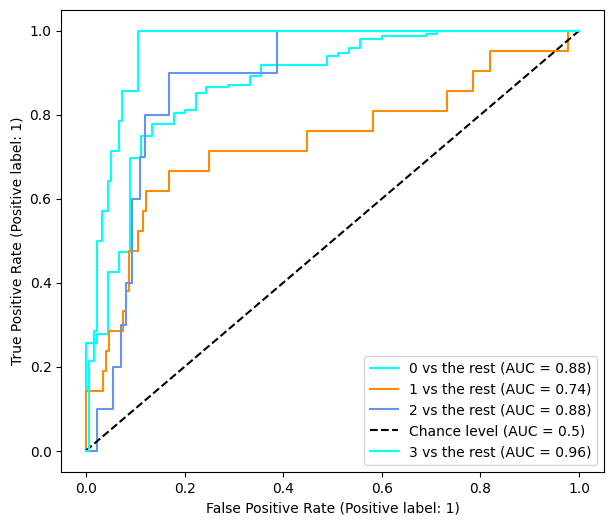

0.8629589846915046
0.7233390005667233


In [67]:
print(best_params)

y_p = rf_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, label_names, ax) #, ["Healthy/DM","PDR", "NPDR"]"Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()


y_prob = rf_best.predict_proba(x_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)


fig, ax = plt.subplots(figsize=(7, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

if num_classes == 2:
    RocCurveDisplay.from_predictions(
        y_test,
        y_prob[:, 1],
        name="ROC curve",
        ax=ax,
        color="red",
    )
else:
    for class_id, color in zip(range(num_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{class_id} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )


if num_classes == 2:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob[:,1],
        multi_class="ovr",
        average="macro",
    )
else:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob,
        multi_class="ovr",
        average="macro",
    )
plt.show()
print(mean_auc)
print(cohen_kappa_score(y_test, y_p, weights="quadratic"))

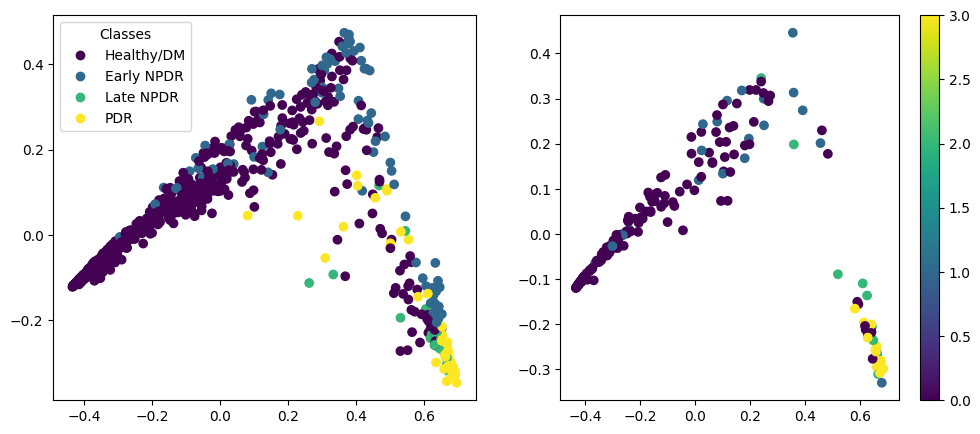

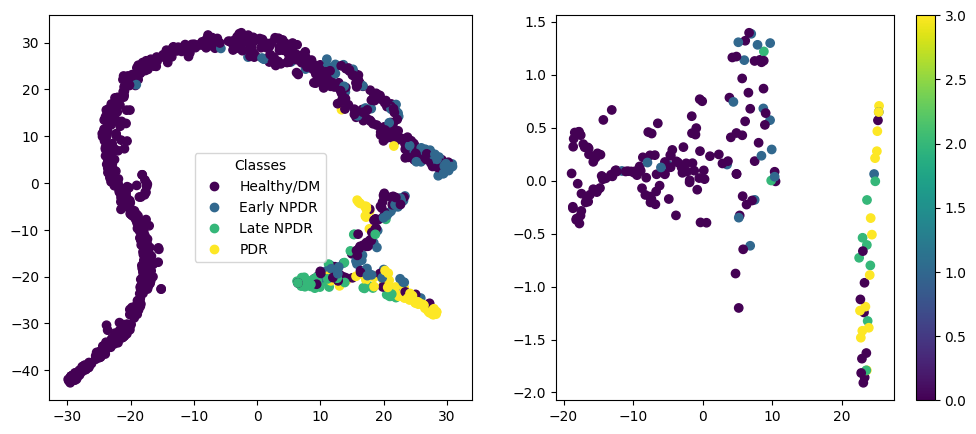

IndexError: index 4 is out of bounds for axis 0 with size 4

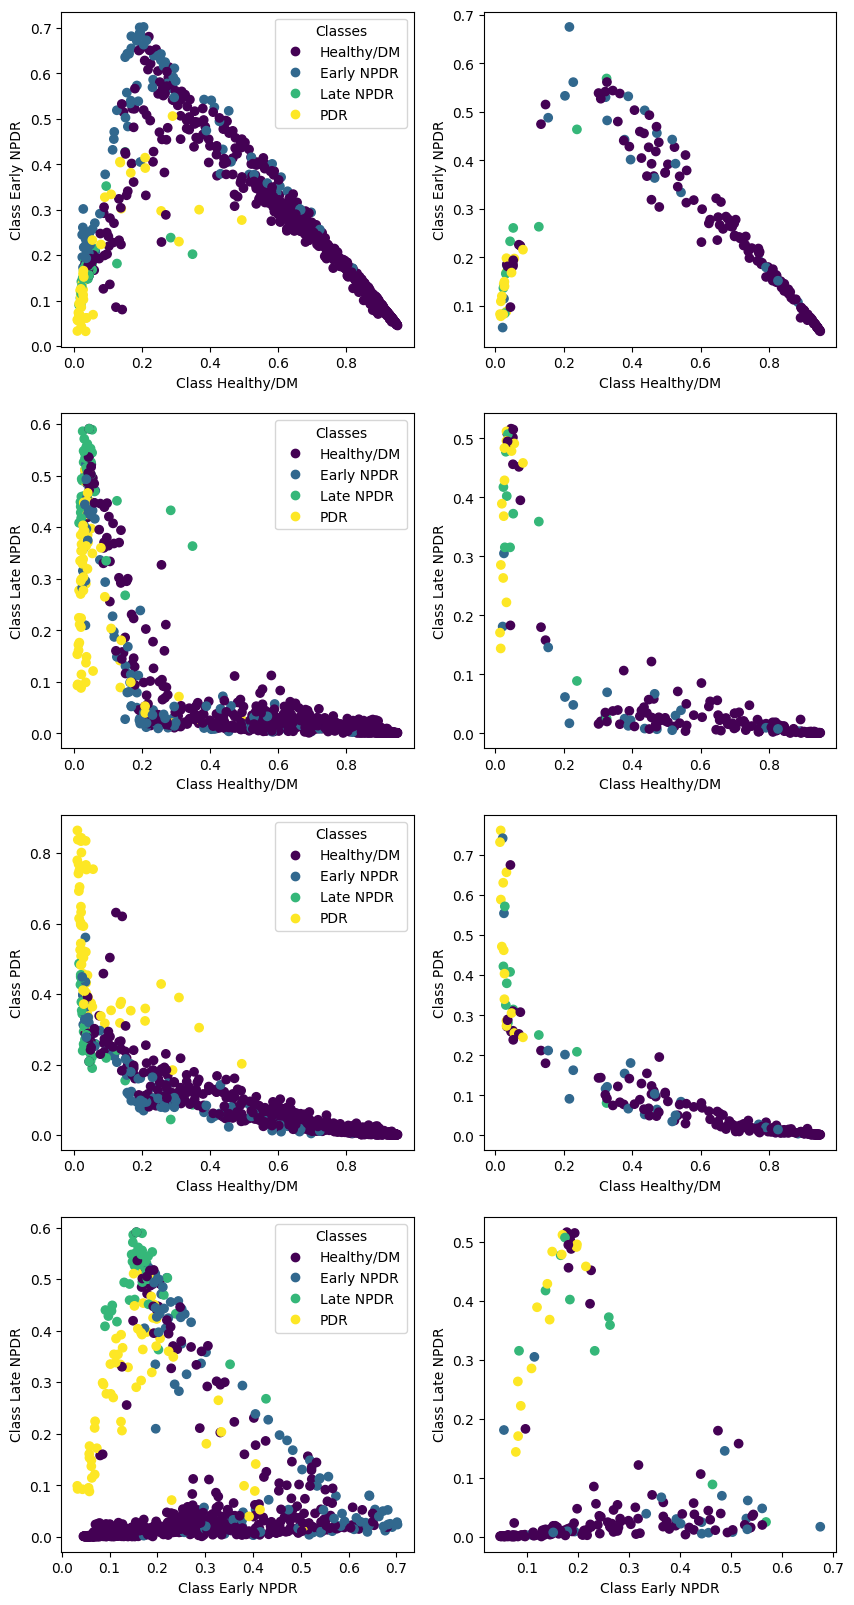

In [24]:
# tsne embedding for visualization
y_prob_train = rf_best.predict_proba(x_train)
y_prob_test = rf_best.predict_proba(x_test)

evaluation.pca_transform_plot(y_prob_train, y_prob_test, y_train, y_test, label_names)
evaluation.tsne_transform_plot(y_prob_train, y_prob_test, y_train, y_test, label_names)
evaluation.embedding_plot(y_prob_train, y_prob_test, y_train, y_test, label_names)

In [ ]:


#faz_features = graph_2_featues.copy()
#for feature in faz_features:
#    faz_features[faz_features.index(feature)] = "faz_" + feature
#
#seg_features = ["global_mask_ratio", "top_left_ratio", "top_right_ratio", "bottom_left_ratio", "bottom_right_ratio"]

#feature_names = graph_1_features + graph_2_featues + global_node_features+ faz_features + seg_features
#print(len(feature_names))

70


In [55]:
# feature name 

feature_names = features_label_dict["graph_1"] + features_label_dict["graph_2"]

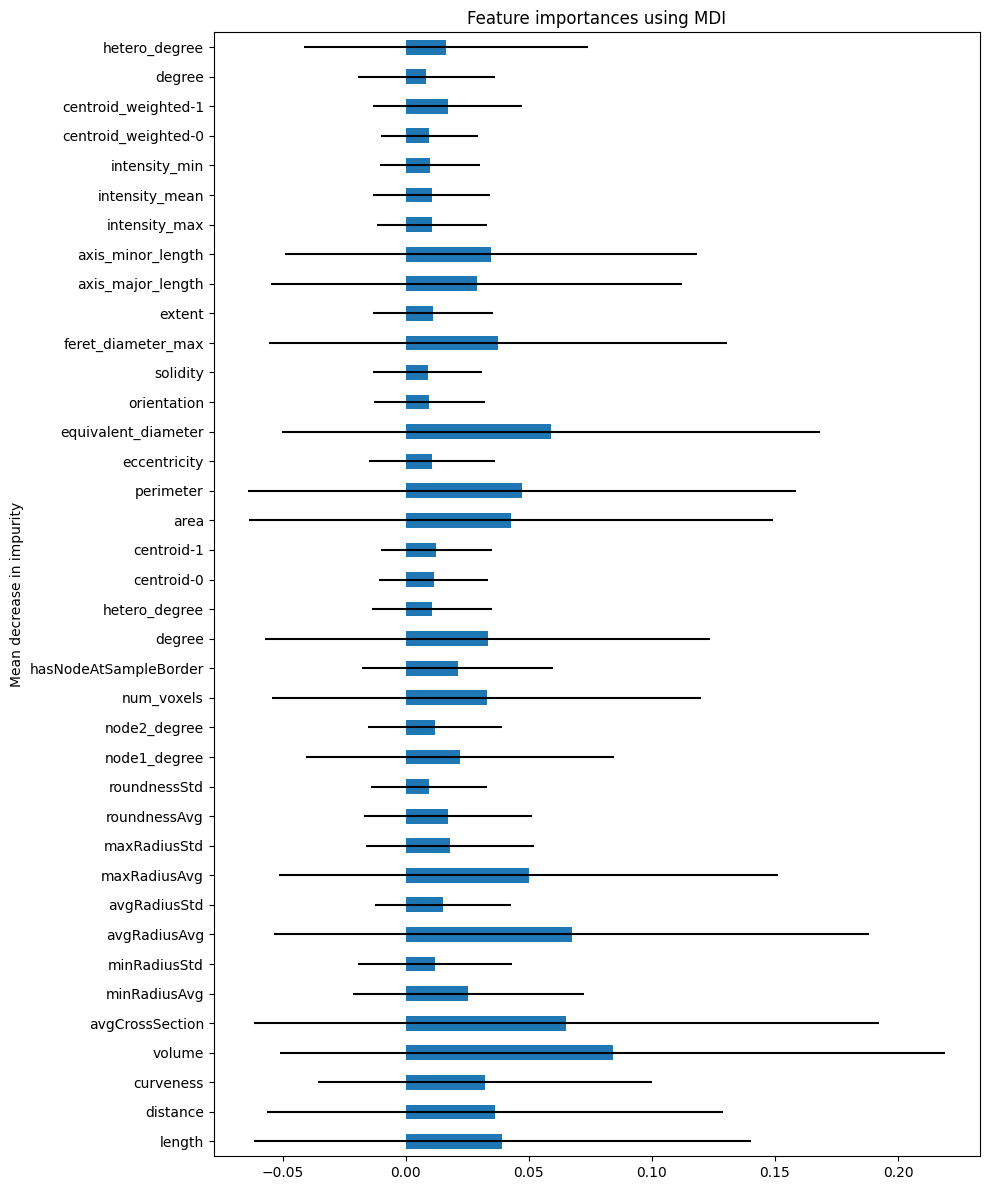

In [56]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)

forest_importances = pd.Series(importances)

fig, ax = plt.subplots(figsize=(10, 12))

forest_importances.plot.barh(xerr=std, ax=ax)
# add feature names as x-axis labels, avoid overwriting
ax.set_yticklabels(feature_names) # , rotation=90
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# last features are the segmentation features

In [ ]:
#param_grid = {'learning_rate' : [0.5, 0.1, 0.01], 'max_iter' : [100,200]}  #HistGradientBoostingClassifier

#param_grid = {'n_estimators': [100,  300]}  #AdaBoostClassifier

param_grid = {'C' : [0.1, 1], 'gamma' : [0.1, 1], 'kernel' : ["rbf", "linear"] , 'probability' : [True]} #SVC #, "poly", "sigmoid"

best_params = None
best_metric = 0

# Hyperparameter search loop
for param_set in product(*param_grid.values()):
    current_params = dict(zip(param_grid.keys(), param_set))

    # Train the model on the training set
    current_model = SVC(**current_params) 
    current_model.fit(x_train, y_train)

    # Evaluate on the validation set
    val_predictions = current_model.predict(x_test)
    val_prob_pred = current_model.predict_proba(x_test)
    current_accuracy = balanced_accuracy_score(y_test, val_predictions)
    if num_classes == 2:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred[:,1],
            multi_class="ovr",
            average="macro",
        )
    else:
        current_auc = roc_auc_score(
            y_true=y_test,
            y_score = val_prob_pred,
            multi_class="ovr",
            average="macro",
        )
    kappa = cohen_kappa_score(y_test, val_predictions, weights="quadratic") # , weights="quadratic"
    metric =  kappa

    # Update best parameters if current model is better
    if metric > best_metric:
        best_metric = metric
        best_params = current_params
        print(best_metric)


alt_cls_best = SVC(**best_params) # , class_weight='balanced'
_=alt_cls_best.fit(x_train, y_train)


0.684820173939463


{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear', 'probability': True}
0.8238341968911918
0.6155706397641881


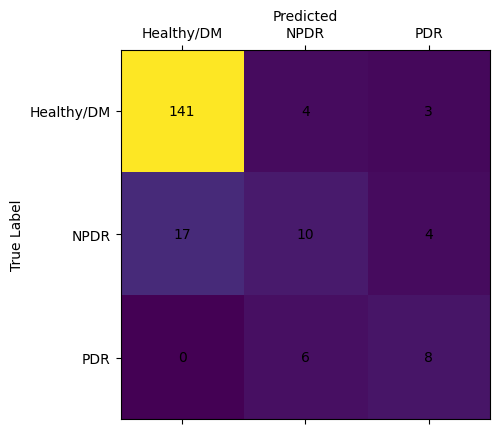

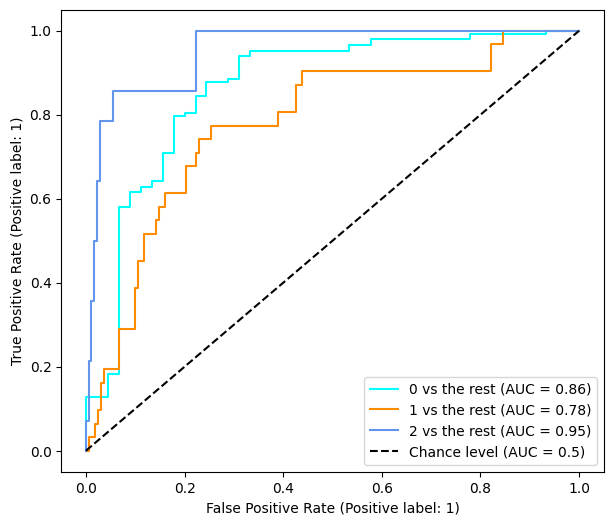

0.8656493097433406
0.684820173939463


In [ ]:
print(best_params)
labels = ["Healthy/DM", "NPDR", "PDR"]

y_p = alt_cls_best.predict(x_test)
print(accuracy_score(y_test, y_p))
print(balanced_accuracy_score(y_test, y_p))
fig, ax = plt.subplots()
evaluation.plot_confusion_matrix(y_test, y_p, labels, ax) #, ["Healthy/DM","PDR", "NPDR"]"Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
plt.show()


y_prob = alt_cls_best.predict_proba(x_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)


fig, ax = plt.subplots(figsize=(7, 6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

if num_classes == 2:
    RocCurveDisplay.from_predictions(
        y_test,
        y_prob[:, 1],
        name="ROC curve",
        ax=ax,
        color="red",
    )
else:
    for class_id, color in zip(range(num_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_prob[:, class_id],
            name=f"{class_id} vs the rest",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )


if num_classes == 2:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob[:,1],
        multi_class="ovr",
        average="macro",
    )
else:
    mean_auc = roc_auc_score(
        y_true=y_test,
        y_score = y_prob,
        multi_class="ovr",
        average="macro",
    )
plt.show()
print(mean_auc)

print(cohen_kappa_score(y_test, y_p, weights="quadratic"))